# Importing Libraries

In [ ]:
# import zipfile

# # Specify the path to the zip file and the directory to extract to
# zip_file_path = '/content/drive/MyDrive/archive.zip'
# extract_to_path = '/content/sample_data'

# # Open the zip file for reading
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Extract all the files to the specified directory
#     zip_ref.extractall(extract_to_path)


In [ ]:
!pip install onnx
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Loading and performing Augmentation on dataset

In [ ]:
# # transforming training dataset 
# stats = ((0.485), (0.229))

# train_tranforms = Compose([transforms.Resize([28,28]),
#                            transforms.RandomCrop(28),
#                            transforms.CenterCrop(28),
#                            transforms.ToTensor(),
#                            transforms.Normalize(*stats,inplace=True)])

# dev_transforms = Compose([transforms.Resize([28,28]),
#                         transforms.ToTensor(),
#                         transforms.Normalize(*stats,inplace=True)])


# train_dataset = MNIST(root="data/", download=True, transform=train_tranforms)
# test_dataset = MNIST(root="data/",train=False, download=True, transform=dev_transforms)

# print("length of train dataset: ", len(train_dataset))
# print("length of train dataset: ", len(test_dataset))

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

# transforming training dataset 
stats = ((0.5), (0.5))

train_transforms = transforms.Compose([
    transforms.Resize([28,28]),
    transforms.RandomCrop(28),
    transforms.CenterCrop(28),
    transforms.Grayscale(),
    transforms.ToTensor(),
     transforms.Lambda(lambda x: 1 - x),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

dev_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize([28,28]),
    transforms.ToTensor(),
     transforms.Lambda(lambda x: 1 - x),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Load the datasets using the ImageFolder class
train_dataset = ImageFolder("/content/drive/MyDrive/SudokuDataset/assets", transform=train_transforms)


# Define the size of the development set
dev_size = 0.2  # 20% of the training set

# Split the training dataset into training and development sets
num_train = len(train_dataset)
num_dev = int(dev_size * num_train)
num_train = num_train - num_dev

train_dataset, test_dataset = random_split(train_dataset, [num_train, num_dev])

print("length of train dataset: ", len(train_dataset))
print("length of dev dataset: ", len(test_dataset))


length of train dataset:  5040
length of dev dataset:  1259


Shape of image is:  torch.Size([1, 28, 28])
Label is:  8


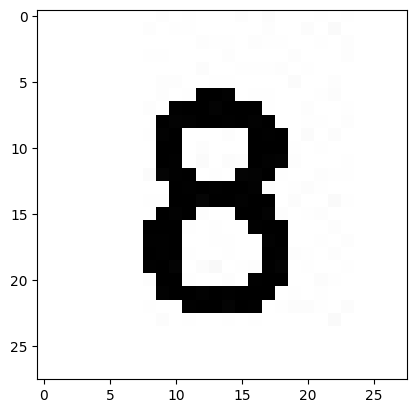

In [ ]:
def show_img(dataset):
    im , label = dataset
    print("Shape of image is: ", im.shape)
    print("Label is: ",label)
    plt.imshow(im.permute(1,2,0),cmap="gray")
    
show_img(train_dataset[98])

In [ ]:
# count classes in dataset
def count_classes ( dataset ):
    dict = {}
    for i in range(len(dataset.classes)):
        dict[dataset.classes[i]] = 0
    
    for _, lb in dataset:
        dict[dataset.classes[lb]] +=1
    print(dict)

# print("Length of Train Dataset is: ")
# count_classes(train_dataset)

# print("Length of test Dataset is: ")
# count_classes(test_dataset)

# HyperParams

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True)


data_loader = {
    "train": train_loader,
    "val": test_loader
}

image_datasets = {
    "train": train_dataset,
    "val" : test_dataset
}

Shape of loader:  torch.Size([64, 1, 28, 28])


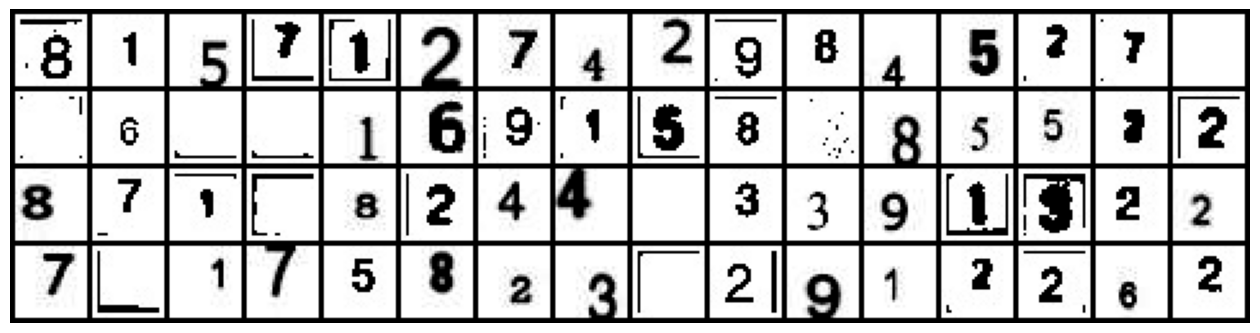

In [ ]:
for i, l in train_loader:
    print("Shape of loader: ",i.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(i, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # First convolutional layer with max pooling
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Second convolutional layer with max pooling
        x = x.view(-1, 64*4*4)  # Flatten the output of the second convolutional layer
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)  # Output layer
        return x

model = LeNet().to(device)


# Applying xavier initialization
def init_normal(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)


model.apply(init_normal)
summary(model,(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
            Conv2d-2             [-1, 64, 8, 8]          51,264
            Linear-3                  [-1, 512]         524,800
            Linear-4                   [-1, 10]           5,130
Total params: 582,026
Trainable params: 582,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 2.22
Estimated Total Size (MB): 2.40
----------------------------------------------------------------


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [ ]:
def train_model(model,epochs, Lr, train_loader,val_loader,batch_size,val_batch_size,L2_regularization,step_lr):
    
    history = {
        "train-accu": [],
        "train-loss": [],
        "val-accu": [],
        "val-loss": [],
        "lr": []
    }
    
    model = model.to(device)

    #----------------------------[ SGD ]------------------------------------------------
    # optimizer = torch.optim.SGD(model.parameters(), lr=Lr, weight_decay=L2_regularization)

    #----------------------------[ Adam ]------------------------------------------------
    optimizer = torch.optim.Adam(model.parameters(), lr=Lr, weight_decay=L2_regularization)

    #----------------------------[ RMSProp ]----------------------------------------------
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=Lr, weight_decay=L2_regularization)

    #----------------------------[ Exponential Lr decay ]---------------------------------
    # schedular = torch.optim.lr_scheduler.ExponentialLR(optimizer,step_lr)

    #----------------------------[ oneCycle Lr ]---------------------------------
    schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epochs)


    print("[INFO] Starting Training....")
    print("[INFO] Using: ", device)
    print("\n")
    for i in range(epochs):
        model.train()
        
        train_loss = 0
        tran_accu = 0
        val_accu = 0
        val_loss = 0
        
        for img, label in train_loader:
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()

            output = model(img)
            curr_loss = F.cross_entropy(output, label)
            
            _, preds = torch.max(output, dim = 1)
            curr_accu = (torch.sum((preds== label)).item()) / batch_size
            
            curr_loss.backward()
            optimizer.step()
                
            tran_accu += curr_accu
            train_loss += curr_loss.item()
        
        with torch.no_grad():
            for img, label in val_loader:
                img = img.to(device)
                label = label.to(device)
                model.eval()
                
                outputs = model(img).to(device)
                valid_loss = F.cross_entropy(outputs, label)
                
                _, val_pred = torch.max(outputs, dim=1)
                valid_accu = (torch.sum((val_pred== label)).item()) / val_batch_size
                
                val_loss += valid_loss.item()
                val_accu += valid_accu
                
        history["lr"].append(schedular._last_lr)
    
        schedular.step()
        
        train_loss = train_loss / len(train_loader)
        tran_accu = tran_accu / len(train_loader)
        val_loss = val_loss / len(val_loader)
        val_accu = val_accu / len(val_loader)

        print("LrRate: ",history["lr"][-1])
        print(f"epoch: {i+1} | train-acc:{tran_accu:.2f} | val-acc: {val_accu:.2f} | train-loss: {train_loss:.2f} | val-loss: {val_loss:.2f}")
        print("\n")
        history['train-loss'].append(train_loss)
        history['train-accu'].append(tran_accu)
        history['val-loss'].append(val_loss)
        history['val-accu'].append(val_accu)
    return history

def evaluate(model, test_loader):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        test_loss = 0
        test_accu = 0
        total_samples = 0
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)

            outputs = model(img)
            test_loss += F.cross_entropy(outputs, label).item()

            _, test_pred = torch.max(outputs, dim=1)
            test_accu += torch.sum(test_pred == label).item()

            total_samples += label.size(0)

        test_loss = test_loss / len(test_loader)
        test_accu = test_accu / total_samples
        print("[INFO] Evaluation on Model ")
        print(f"Test Accuracy: {test_accu:.2f}\nTest Loss: {test_loss:.2f}")



In [ ]:
batch_size = 64
epochs = 10
Lr = 0.00005
val_loader = test_loader
val_batch_size = batch_size
L2_regularization = .001  
step_lr=0.001 #gamma


history = train_model(model,epochs, Lr, train_loader,val_loader,
                      batch_size, val_batch_size, L2_regularization, step_lr)
evaluate(model,test_loader)

[INFO] Starting Training....
[INFO] Using:  cuda


LrRate:  [0.0040000000000000036]
epoch: 1 | train-acc:0.52 | val-acc: 0.78 | train-loss: 1.41 | val-loss: 0.62


LrRate:  [0.00400425285492248]
epoch: 2 | train-acc:0.85 | val-acc: 0.88 | train-loss: 0.43 | val-loss: 0.33


LrRate:  [0.0040170106660742805]
epoch: 3 | train-acc:0.92 | val-acc: 0.90 | train-loss: 0.22 | val-loss: 0.27


LrRate:  [0.004038271172742081]
epoch: 4 | train-acc:0.95 | val-acc: 0.93 | train-loss: 0.15 | val-loss: 0.15


LrRate:  [0.004068030607515441]
epoch: 5 | train-acc:0.97 | val-acc: 0.94 | train-loss: 0.09 | val-loss: 0.14


LrRate:  [0.004106283696954399]
epoch: 6 | train-acc:0.97 | val-acc: 0.94 | train-loss: 0.09 | val-loss: 0.12


LrRate:  [0.004153023662524]
epoch: 7 | train-acc:0.98 | val-acc: 0.95 | train-loss: 0.06 | val-loss: 0.12


LrRate:  [0.004208242221795361]
epoch: 8 | train-acc:0.99 | val-acc: 0.96 | train-loss: 0.04 | val-loss: 0.07


LrRate:  [0.004271929589913417]
epoch: 9 | train-acc:0.

In [ ]:
def show_losses(history):
  plt.plot(history["train-loss"],label='Train Loss')
  plt.plot(history["val-loss"], label='Validation Loss')
  plt.legend()

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True) 
  plt.show()

def show_accuracies(history):
  plt.plot(history["train-accu"],label='Train Accuracy')
  plt.plot(history["val-accu"], label="Validation Accuracy")
  
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  
  plt.grid(True) 
  plt.legend()
  plt.show()

def show_learningRate(history):
  plt.plot(history["lr"])

  plt.xlabel("Epochs")
  plt.ylabel("Lr-Rate")
  plt.grid(True) 
  plt.show()



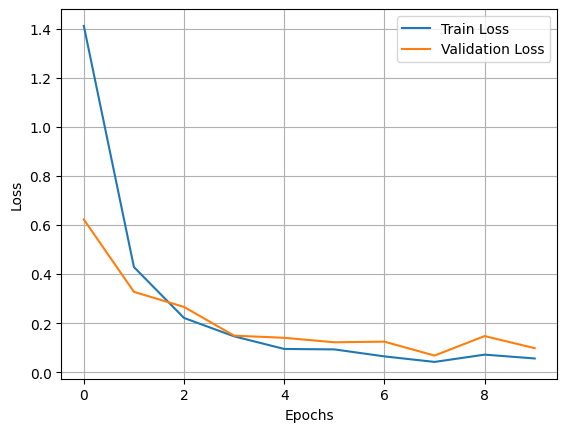

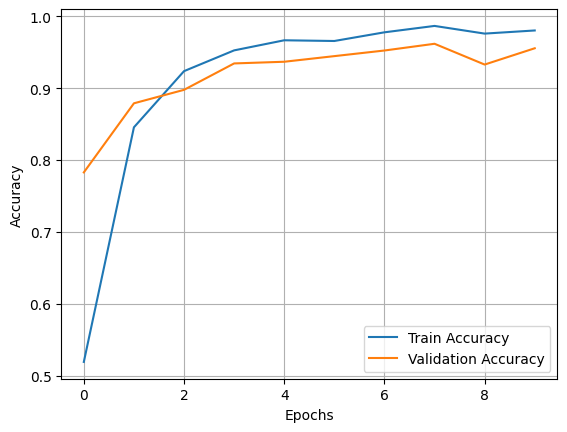

In [ ]:
show_losses(history)
show_accuracies(history)


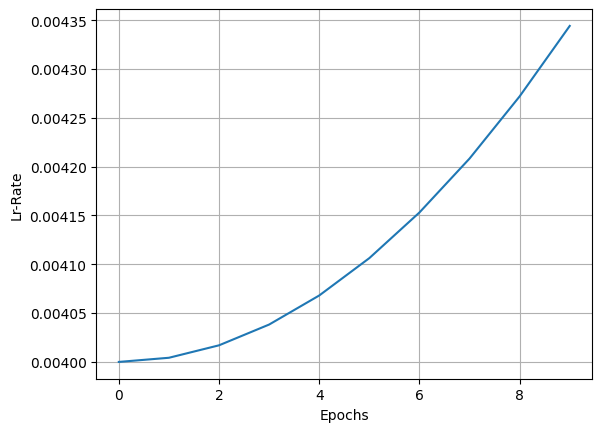

In [ ]:
show_learningRate(history)

In [ ]:
# def test_img(dataset, model):
#     im , label = dataset
#     im = im.to(device)
    
#     # If the image tensor has only one channel, add an extra dimension to match the expected shape of the model
#     im = im.unsqueeze(0)
#     print(im.shape)
#     model = model.to(device)
#     model.eval()
    
#     out = model(im)
#     _, pred = torch.max(out, dim=1)

#     print("Prediction:", pred.item())
#     print("Label is: ",label.item()) 

# test_img(test_dataset[8], model)

torch.Size([1, 1, 28, 28])
Predicted label: 0, Actual label: 0
Shape of image is:  torch.Size([1, 28, 28])
Label is:  0


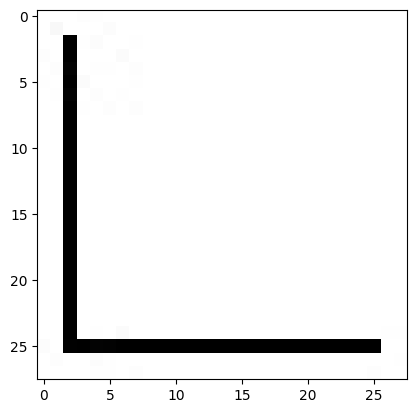

In [ ]:
def test(model, train_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get one image from the training set
    image, label = test_dataset[100]

   

    # Add batch dimension to the image tensor
    image = image.unsqueeze(0).to(device)
    print(image.shape)

    # Forward pass
    output = model(image)

    # Get predicted class label
    _, pred_label = torch.max(output.data, 1)

    print(f"Predicted label: {pred_label.item()}, Actual label: {label}")

test(model, train_dataset)
show_img(test_dataset[100])

In [ ]:
import torch

model.to("cpu")
torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("model.pth"))

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "lenet-2-SodukuImg.onnx")

import cv2
net=cv2.dnn.readNet("lenet-2-SodukuImg.onnx")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

